In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from keras import layers, models, callbacks, regularizers
import tensorflow as tf
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import shap
from keras.callbacks import EarlyStopping

In [21]:
albums = pd.read_csv('../data/new/albums_colors_nudity_skin_gender.csv')
features = pd.read_csv('../data/new/album_features_complete.csv')

In [22]:
df = albums.merge(features, on='album_id')
df = df.drop_duplicates()
print(df.columns)

Index(['artist_name', 'artist_id', 'genre', 'album_id', 'album_name',
       'release_date', 'total_tracks', 'popularity', 'image_url_x',
       'genre_condensed', 'black', 'blue', 'gray', 'green', 'orange', 'pink',
       'purple', 'red', 'white', 'yellow', 'face', 'female_genitalia_covered',
       'buttocks_exposed', 'female_breast_exposed', 'female_genitalia_exposed',
       'male_breast_exposed', 'anus_exposed', 'feet_exposed', 'belly_covered',
       'feet_covered', 'armpits_covered', 'armpits_exposed', 'belly_exposed',
       'male_genitalia_exposed', 'anus_covered', 'female_breast_covered',
       'buttocks_covered', 'skin_percentage', 'gender', 'count_person',
       'max_confidence_person', 'count_car', 'max_confidence_car',
       'count_bicycle', 'max_confidence_bicycle', 'count_dog',
       'max_confidence_dog', 'count_cat', 'max_confidence_cat', 'count_chair',
       'max_confidence_chair', 'count_book', 'max_confidence_book',
       'count_bottle', 'max_confidence_bottle

In [23]:
df = df.drop(['artist_name','artist_id','genre','album_name','release_date','image_url_x','image_url_y','album_id'],axis=1)
df = df.drop(['max_confidence_person', 'max_confidence_car', 'max_confidence_bicycle', 'max_confidence_dog', 'max_confidence_cat', 
              'max_confidence_chair', 'max_confidence_book', 'max_confidence_bottle', 'avg_detection_confidence', 'color_1_hex',
       'color_1_percentage', 'color_2_hex', 'color_2_percentage',
       'color_3_hex', 'color_3_percentage', 'color_4_hex',
       'color_4_percentage', 'color_5_hex', 'color_5_percentage','text_content', 'width', 'height', 'aspect_ratio'], axis=1)

In [24]:
# Feature Cleaning

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

#group gender diverse categories
group_map = {'non-binary':'gender_diverse',
    'trans woman': 'gender_diverse',
    'genderfluid':'gender_diverse'}
df['gender'] = df['gender'].replace(group_map)

# One‑hot encode the genres/gender
df = pd.get_dummies(df, columns=['genre_condensed'], prefix='genre')
df = pd.get_dummies(df, columns=['gender'], prefix='gender')

In [25]:
print(df.columns)
print(df.shape)
# Check for missing values
print(df.isnull().sum())

Index(['total_tracks', 'popularity', 'black', 'blue', 'gray', 'green',
       'orange', 'pink', 'purple', 'red', 'white', 'yellow', 'face',
       'female_genitalia_covered', 'buttocks_exposed', 'female_breast_exposed',
       'female_genitalia_exposed', 'male_breast_exposed', 'anus_exposed',
       'feet_exposed', 'belly_covered', 'feet_covered', 'armpits_covered',
       'armpits_exposed', 'belly_exposed', 'male_genitalia_exposed',
       'anus_covered', 'female_breast_covered', 'buttocks_covered',
       'skin_percentage', 'count_person', 'count_car', 'count_bicycle',
       'count_dog', 'count_cat', 'count_chair', 'count_book', 'count_bottle',
       'total_object_count', 'has_people', 'avg_brightness', 'brightness_std',
       'is_dark', 'is_bright', 'avg_saturation', 'is_vibrant', 'is_muted',
       'is_warm', 'is_cool', 'text_count', 'has_text', 'has_parental_advisory',
       'text_coverage_ratio', 'edge_density', 'is_complex', 'is_minimal',
       'horizontal_symmetry', 'is_sy

In [26]:
# target - popularity is above median
y_targ = df.popularity.values
cutoff = np.percentile(y_targ, 50)

# binary target: 1 if above median, 0 if below
y_clf = (y_targ >= cutoff).astype(int)
print(f"Class distribution - Overall: {np.bincount(y_clf)}")
print(f"Class imbalance ratio: 1:{np.bincount(y_clf)[0]/np.bincount(y_clf)[1]:.2f}")
### classes not imbalanced

Class distribution - Overall: [1617 1655]
Class imbalance ratio: 1:0.98


In [56]:
X = df.drop(columns=['popularity']).values

# train/val/test split
X_train_val, X_test, y_train_val_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
X_train, X_val, y_train_clf, y_val_clf = train_test_split(
    X_train_val, y_train_val_clf, test_size=0.25, random_state=42, stratify=y_train_val_clf)

In [28]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

ANN Classifying Popularity

In [ ]:
input_shape = X_train.shape[1]

def build_model(input_shape):
    model = keras.Sequential([
        # Input Layer + Dense + BN + Dropout
        layers.Dense(
            64,
            activation='relu',
            input_shape=(input_shape,),
            kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden Layer 1
        layers.Dense(
            32,
            activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden Layer 2
        layers.Dense(
            32,
            activation='relu',
            kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output Layer
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model




In [34]:
print(X_train.shape)        
print(y_train_clf.shape)    
print("X_val:", X_val.shape)
print("y_val:", y_val_clf.shape)

(1962, 78)
(1962,)
X_val: (655, 78)
y_val: (655,)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4887 - loss: 2.0586 - val_accuracy: 0.5344 - val_loss: 1.7131
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4948 - loss: 1.9026 - val_accuracy: 0.5450 - val_loss: 1.6661
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.5321 - loss: 1.7841 - val_accuracy: 0.5466 - val_loss: 1.6299
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5492 - loss: 1.7073 - val_accuracy: 0.5634 - val_loss: 1.6034
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5287 - loss: 1.6931 - val_accuracy: 0.5740 - val_loss: 1.5766
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5190 - loss: 1.6423 - val_accuracy: 0.6061 - val_loss: 1.5494
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5075 - loss: 1.6191 - val_accuracy: 0.5924 - val_loss: 1.5219
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5155 - loss: 1.5790 - val_accuracy: 

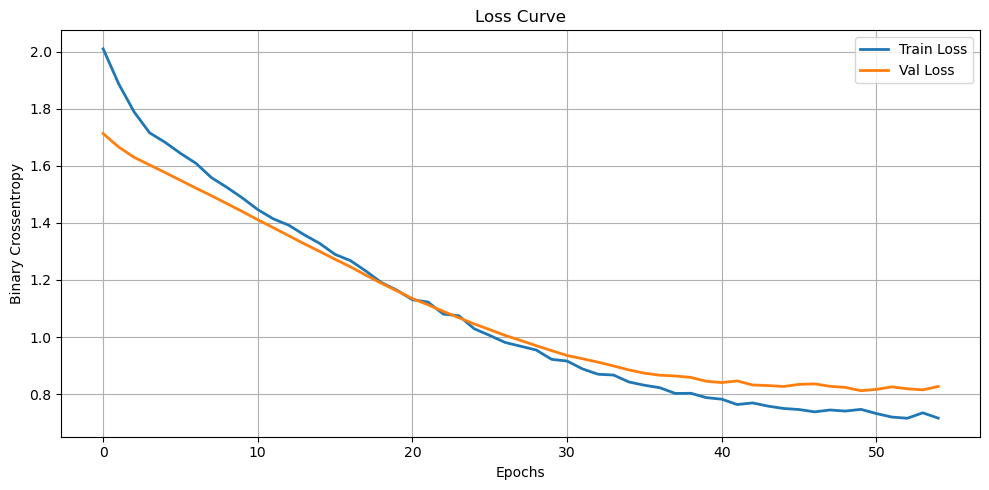

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.6596    0.5802    0.6174       324
           1     0.6324    0.7069    0.6676       331

    accuracy                         0.6443       655
   macro avg     0.6460    0.6436    0.6425       655
weighted avg     0.6459    0.6443    0.6428       655

F1 Score: 0.6676176890156919


In [35]:
# Build and train the model
model = build_model(input_shape)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train, y_train_clf,
    validation_data=(X_val, y_val_clf),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation with F1 score
y_pred_prob = model.predict(X_val).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📋 Classification Report:")
print(classification_report(y_val_clf, y_pred, digits=4))
print("F1 Score:", f1_score(y_val_clf, y_pred))

Trying Random Forest for comparison

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train_clf)
print(f1_score(y_val_clf, model.predict(X_val)))
# about the same as the neural network

0.6282245827010622


Check Feature Importance

/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marievaughan/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marievaughan/miniconda3/lib/pytho

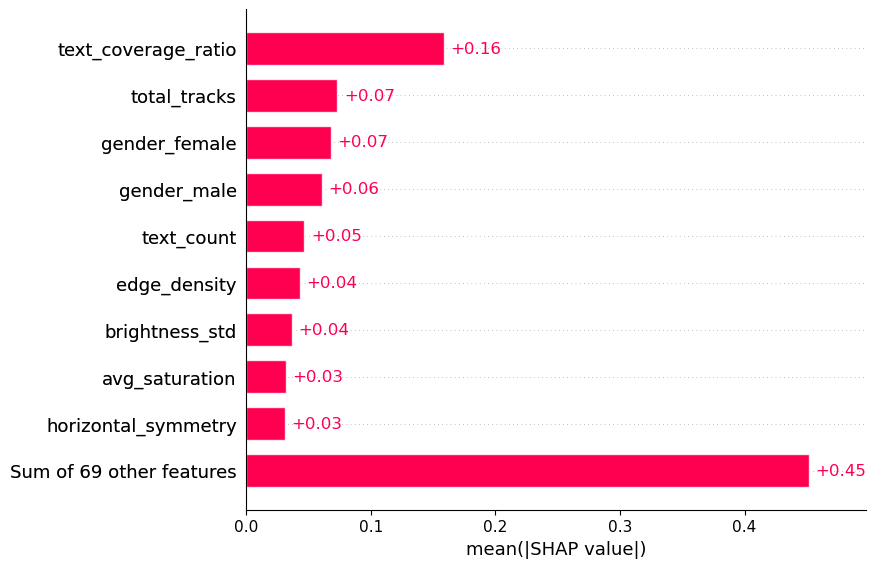

/var/folders/s_/db3xbm4s4xvfydq4_s8vwkwm0000gn/T/ipykernel_50511/1095745035.py:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_df)


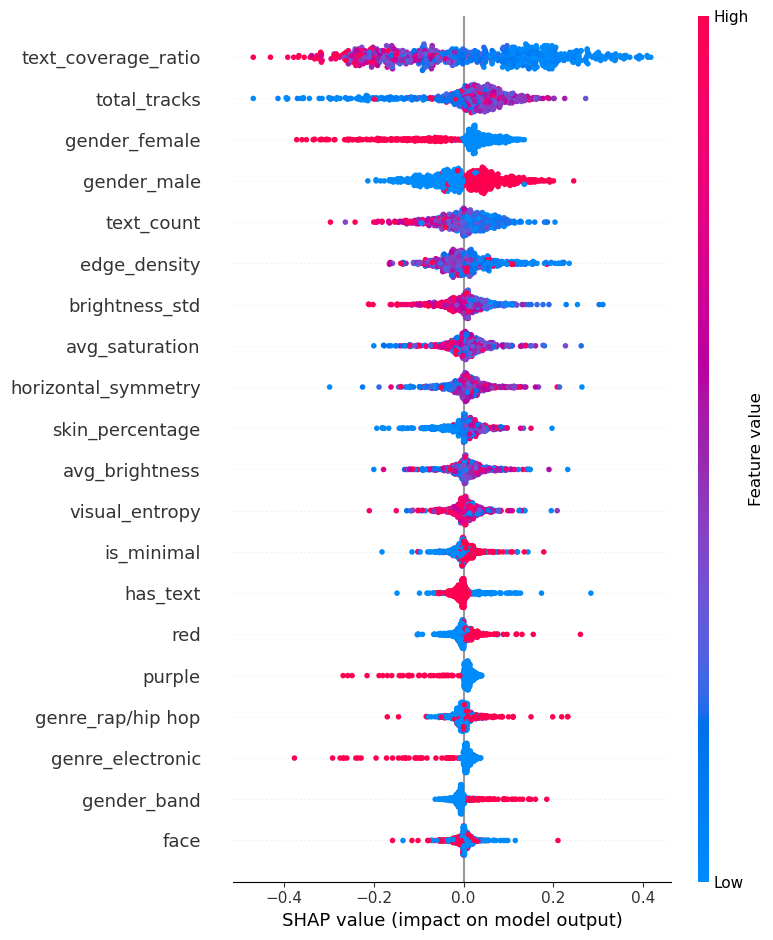

In [42]:
# Using shap

# Assume you know your feature names:
feature_names = ['total_tracks', 'black', 'blue', 'gray', 'green',
       'orange', 'pink', 'purple', 'red', 'white', 'yellow', 'face',
       'female_genitalia_covered', 'buttocks_exposed', 'female_breast_exposed',
       'female_genitalia_exposed', 'male_breast_exposed', 'anus_exposed',
       'feet_exposed', 'belly_covered', 'feet_covered', 'armpits_covered',
       'armpits_exposed', 'belly_exposed', 'male_genitalia_exposed',
       'anus_covered', 'female_breast_covered', 'buttocks_covered',
       'skin_percentage', 'count_person', 'count_car', 'count_bicycle',
       'count_dog', 'count_cat', 'count_chair', 'count_book', 'count_bottle',
       'total_object_count', 'has_people', 'avg_brightness', 'brightness_std',
       'is_dark', 'is_bright', 'avg_saturation', 'is_vibrant', 'is_muted',
       'is_warm', 'is_cool', 'text_count', 'has_text', 'has_parental_advisory',
       'text_coverage_ratio', 'edge_density', 'is_complex', 'is_minimal',
       'horizontal_symmetry', 'is_symmetric', 'visual_entropy',
       'genre_afrobeats', 'genre_blues', 'genre_country/folk',
       'genre_electronic', 'genre_indie', 'genre_k-pop', 'genre_kids',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap/hip hop',
       'genre_reggae', 'genre_relaxed', 'genre_religious', 'genre_rock/alt',
       'genre_soul/jazz', 'gender_band', 'gender_female',
       'gender_gender_diverse', 'gender_male'] 

# Convert to DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# Use a small background sample from training data
background = X_train_df.sample(100, random_state=42)

# Create SHAP explainer (model.predict works great with Keras)
explainer = shap.Explainer(model.predict, background)

# Compute SHAP values for the validation set
shap_values = explainer(X_val_df)

# Bar plot: global importance of features
shap.plots.bar(shap_values)

# Beeswarm plot: how features push predictions up/down
shap.summary_plot(shap_values, X_val_df)

More Feature Engineering + Condensing to top 10

In [51]:
import pandas as pd

df_reduced = df.drop(columns = 'popularity')

# Display top 10 features based on mean absolute SHAP values
shap_means = df_reduced.abs().mean().sort_values(ascending=False)
top_10_features = shap_means.head(10).reset_index()
top_10_features.columns = ['feature', 'mean(|SHAP|)']
print(top_10_features)

              feature  mean(|SHAP|)
0      avg_brightness    102.076019
1      avg_saturation     90.893287
2      brightness_std     56.017833
3     skin_percentage     15.476452
4        total_tracks     15.469438
5      visual_entropy      6.298370
6          text_count      3.737469
7  total_object_count      1.901895
8        count_person      1.287286
9            has_text      0.812653


Trying model again with only top 10 features

/Users/marievaughan/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


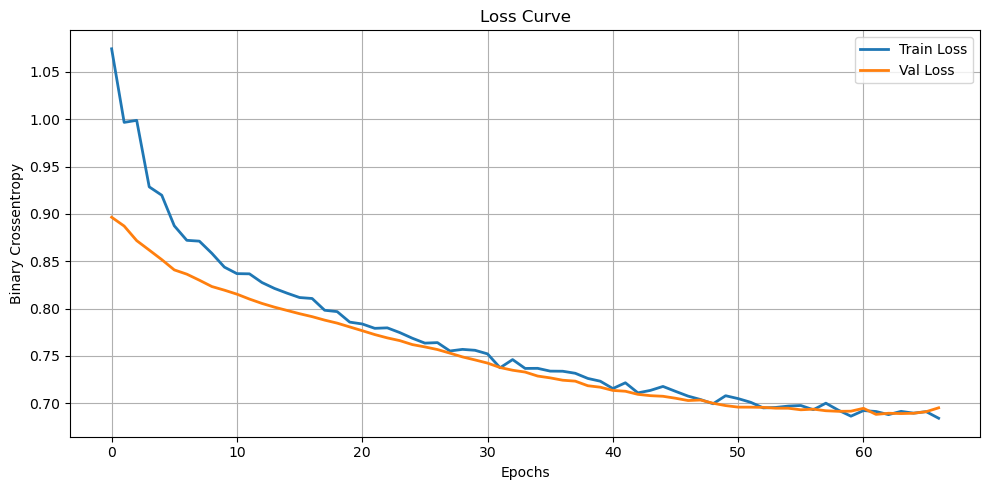

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

📋 Classification Report:
              precision    recall  f1-score   support

           0     0.5919    0.7209    0.6501       344
           1     0.6265    0.4849    0.5467       332

    accuracy                         0.6050       676
   macro avg     0.6092    0.6029    0.5984       676
weighted avg     0.6089    0.6050    0.5993       676

F1 Score: 0.5466893039049237


In [53]:
# Selected top 10 features from SHAP
selected_features = [
    "avg_brightness",
    "avg_saturation",
    "brightness_std",
    "skin_percentage",
    "total_tracks",
    "visual_entropy",
    "text_count",
    "total_object_count",
    "count_person",
    "has_text"
]

df_full = albums.merge(features, on='album_id')

# Binary target: 1 if above median popularity, else 0
popularity_cutoff = df_full["popularity"].median()
df_full["popularity"] = (df_full["popularity"] > popularity_cutoff).astype(int)

X = df_full[selected_features]
y = df_full["popularity"]  

# Perform train/val/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build and train Keras model
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC(name='auc')])
    return model

model = build_model(X_train.shape[1])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation with F1 score
y_pred_prob = model.predict(X_val).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred, digits=4))
print("F1 Score:", f1_score(y_val, y_pred))



Trying First Model again with all features but split by gender

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Reload dataset
df = pd.read_csv("/mnt/data/album_features_with_gender.csv")

# Top SHAP features used for modeling
selected_features = [
    "avg_brightness",
    "avg_saturation",
    "brightness_std",
    "skin_percentage",
    "total_tracks",
    "visual_entropy",
    "text_count",
    "total_object_count",
    "count_person",
    "has_text"
]

# Binary target: popularity above median
cutoff = df["popularity"].median()
df["popularity_binary"] = (df["popularity"] > cutoff).astype(int)

# Function to train model and extract feature weights from first dense layer
def get_feature_weights_by_gender(gender_label):
    subset = df[df["gender"] == gender_label]
    X = subset[selected_features]
    y = subset["popularity_binary"]

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Build the model
    input_shape = X_train_scaled.shape[1]
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizers.l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(0.001, 0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train model
    model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)

    # Get input layer weights
    weights, _ = model.layers[0].get_weights()  # shape: (n_features, 64)
    abs_weights = np.mean(np.abs(weights), axis=1)  # average over 64 neurons

    return pd.DataFrame({
        'feature': selected_features,
        f'{gender_label}_abs_weight': abs_weights
    }).sort_values(by=f'{gender_label}_abs_weight', ascending=False).reset_index(drop=True)

# Run for both genders
female_weights = get_feature_weights_by_gender("female")
male_weights = get_feature_weights_by_gender("male")

# Merge and display
comparison_df = pd.merge(female_weights, male_weights, on='feature')
